# Wine Dataset
Below is a short core library to do PCA, centralize normalize, and make scatter plots (similar to the library in the Jupyter Exercise 4). This code will be used in the future sections.

In [27]:
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
import heapq
import math

def normalize(A):
    stds = [np.std(A[r,:]) for r in range(A.shape[0])]
    for r in range(A.shape[0]):
        A[r,:] /= stds[r]
    return A

def centralize(A):
    means = [np.mean(A[r,:]) for r in range(A.shape[0])]
    for r in range(A.shape[0]):
        A[r,:] -= means[r]
    return A

def PCA(A, numComponents, norm = False):
    # First, center the data
    A = centralize(A)
    # If needed, normalize the data as well.
    if norm:
        A = normalize(A)
    
    # Now, compute the SVD, and reduce the dimensions of A.
    U, Sigma, Vt = np.linalg.svd(A)
    D = np.matmul(A.T, U[:,:numComponents])
    
    return D.T

def makeScatterPlot(title, pointsLists, colors, markers):
    # Create plot
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
     
    for i, pointsList in enumerate(pointsLists):
        currColor = colors[i]
        currMarker = markers[i]
        for point in pointsList:
            x, y = point
            ax.scatter(x, y, c=currColor, marker=currMarker)
        
    plt.title(title)
    plt.legend(loc=2)
    plt.show()
    
    

# Problem 1
Here is the code for the first problem:

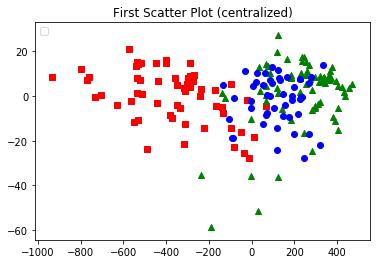

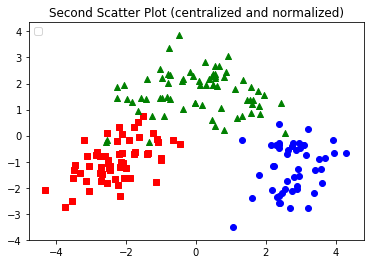

In [31]:
from sklearn.datasets import load_wine
def problemOne():
    samples, labels = load_wine(return_X_y=True)
    colSamples = samples.T
    
    # Parts 1-2 : centralize, do PCA, and make a scatter plot.
    PCAsamples = PCA(colSamples, 2)
    pointsLists = [[PCAsamples[:, i] for i, label in enumerate(labels) if label == target] for target in range(3)]
    colors = ["red", "green", "blue"]
    markers = ["s", "^", "o"]
    makeScatterPlot("First Scatter Plot (centralized)", pointsLists, colors, markers)
    
    # Part 3: Normalize the centered wine dataset, and make another scatter plot
    nPCASamples = PCA(colSamples, 2, norm = True)
    nPointsLists = [[nPCASamples[:, i] for i, label in enumerate(labels) if label == target] for target in range(3)]
    colors = ["red", "green", "blue"]
    markers = ["s", "^", "o"]
    makeScatterPlot("Second Scatter Plot (centralized and normalized)", nPointsLists, colors, markers)
    
    
problemOne()



IMO, the PCA features of the normalized and centralized data would be lead to better classification performance because the different colors are seperated more clearly.

# Problem 2
Here is the code for the second problem. Most of the relevant code is in the "normPDFboi", "NaiveBayesBoi" and "CrossValidationBoi" code stubs.

In [30]:
from sklearn.naive_bayes import GaussianNB

def normPDFboi(mean, std):
    return (lambda x: 1 / math.sqrt(2*np.pi*pow(std, 2)) * np.exp(-pow((x - mean), 2)/2/pow(std, 2)))

class NaiveBayesBoi(object):
    
    def __init__(self, useScikit = False):
        self.means = []
        self.stds = []
        self.useScikit = useScikit
        self.skClassifier = None

    def train(self, pointsLists):
        if not self.useScikit:
            self.means = []
            self.stds = []
            for pointsList in pointsLists:
                pointMatrix = np.array(pointsList).T
                self.means.append(np.mean(pointMatrix, axis = 1))
                self.stds.append(np.std(pointMatrix, axis = 1))
        else:
            self.skClassifier = GaussianNB()
            X = []
            Y = []
            for i, pointsList in enumerate(pointsLists):
                for point in pointsList:
                    X.append(point)
                    Y.append(i)
            self.skClassifier.fit(X, Y)

    def classify(self, point):
        if not self.useScikit:
            probs = []
            for i in range(len(self.means)):
                currProb = 1
                for j in range(len(point)):
                    f = normPDFboi(self.means[i][j], self.stds[i][j])
                    currProb *= f(point[j])
                probs.append(currProb)
            return np.argmax(probs)
        else:
            return self.skClassifier.predict(np.matrix(point))
    
    
class CrossValidationBoi(object):
    
    def __init__(self, k, pointsLists):
        """
        pointsLists = list of lists of points such that if two points are in the same list, they share the same classification.
        """
        self.k = k
        self.pointsLists = pointsLists
        self.pointsTable = {}
        self.masterList = []
        for i, pointsList in enumerate(pointsLists):
            for point in pointsList:
                self.pointsTable[str(point)] = i
                self.masterList.append(point)
    
        # Shuffle the masterList (which contains all of the points, randomly shuffled) and make folds out of it!
        np.random.shuffle(self.masterList)
        self.foldSize = len(self.masterList) / k
        self.folds = [[] for i in range(k)]
        for i, point in enumerate(self.masterList):
            currIndex = min(i / self.foldSize, k - 1)
            self.folds[currIndex].append(point)      
            
    def performValidation(self, useScikit = False):
        fracsCorrect = []

        for i in range(len(self.folds)):
            trainingPoints = []
            testingPoints = []
            for j, fold in enumerate(self.folds):
                if j == i:
                    testingPoints += [point for point in fold]
                else:
                    trainingPoints += [point for point in fold]
            trainingPointsLists = [[] for _  in range(len(self.pointsLists))]
            for point in trainingPoints:
                hval = str(point)
                currIndex = self.pointsTable[hval]
                trainingPointsLists[currIndex].append(point)
            
            # Perform training and classification
            nb = NaiveBayesBoi(useScikit = useScikit)
            nb.train(trainingPointsLists)
            
            numCorrect = 0
            for point in testingPoints:
                classified = nb.classify(point)
                correctAns = self.pointsTable[str(point)]
                # print classified, correctAns
                if self.pointsTable[str(point)] == classified:
                    numCorrect += 1
                    
            fracsCorrect.append( float(numCorrect) / len(testingPoints) )

        mean = np.mean(fracsCorrect)
        variance = np.var(fracsCorrect)
        
        return fracsCorrect, mean, variance
    
    
def questionTwo():
    k = 5
    samples, labels = load_wine(return_X_y=True)
    colSamples = samples.T
    
    # Get centered points lists, and perform Naive Bayes classification
    PCAsamples = PCA(colSamples, 2)
    pointsLists = [[PCAsamples[:, i] for i, label in enumerate(labels) if label == target] for target in range(3)]
    
    print "Only centered data:"
    cv1 = CrossValidationBoi(k, pointsLists)
    fracsCorrect, mean, variance = cv1.performValidation()
    print "Fracs correct = {}\nmean = {}\nvariance = {}\n".format(fracsCorrect, mean, variance)
    
    # Get centered and normalized points lists
    nPCASamples = PCA(colSamples, 2, norm = True)
    nPointsLists = [[nPCASamples[:, i] for i, label in enumerate(labels) if label == target] for target in range(3)]

    print "Centered and normalized (standardized) data:"
    cv2 = CrossValidationBoi(k, nPointsLists)
    fracsCorrect, mean, variance = cv2.performValidation()
    print "Fracs correct = {}\nmean = {}\nvariance = {}\n".format(fracsCorrect, mean, variance)
    
    print "Centered and normalized (standardized) data, using scikit-learn:"
    cv3 = CrossValidationBoi(k, nPointsLists)
    fracsCorrect, mean, variance = cv3.performValidation(useScikit = True)
    print "Fracs correct = {}\nmean = {}\nvariance = {}\n".format(fracsCorrect, mean, variance)
    

questionTwo()
        
        

Only centered data:
Fracs correct = [0.6571428571428571, 0.8571428571428571, 0.8, 0.8, 0.6578947368421053]
mean = 0.754436090226
variance = 0.00669740516705

Centered and normalized (standardized) data:
Fracs correct = [1.0, 1.0, 0.9428571428571428, 0.9714285714285714, 0.9210526315789473]
mean = 0.967067669173
variance = 0.000978325513031

Centered and normalized (standardized) data, using scikit-learn:
Fracs correct = [0.9714285714285714, 0.9428571428571428, 1.0, 0.9428571428571428, 0.9473684210526315]
mean = 0.960902255639
variance = 0.00049477076149



Using the centered data yielded much less accurate results than using standardized data. Using my own implementation of the algorithm yielded similar results to using the pre-implemented algorithm in scikit-learn. Perhaps the scikit-learn implementation uses some optimizations that may yield different results from just the naive algorithm.